# 9th April 2024

We have some predictions about what kinds of range dependencies will lead to modularisation, and which won't. Let's test if they are true?

In [2]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import vmap, value_and_grad, grad, jit, random
import jax.nn as jnn
import math
import optax
import scipy
from mpl_toolkits.mplot3d import Axes3D

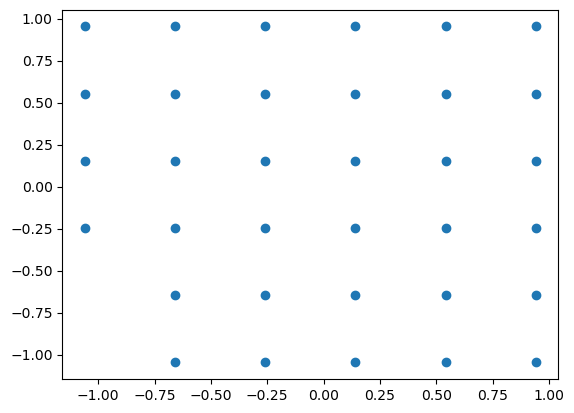

In [40]:
step = 0.4
x, y = np.meshgrid(np.arange(-1, 1+0.0001, step), np.arange(-1, 1+0.0001, step))
points = np.stack([np.ndarray.flatten(x), np.ndarray.flatten(y)])
points_raw = np.copy(points)

# This actually doesn't work, so instead just see it as a set of trial data
# To keep it anticorrelated we go through and send discarded points to there opposite:
v = 0.01
Delta = (-1+np.sqrt(1+v**2))

# Equation of line is y = -1/v x + x_min/v + Delta
movers = points[1,:] < -1/v * points[0,:] - 1/v - Delta -0.5
#movers = np.logical_or(points[1,:] < 2*points[0,:]-0.5, points[1,:] < -2*points[0,:]+0.5)


# So let's do the operation
#points[:,movers] = points[:,movers]*(-1)
points = points[:,np.logical_not(movers)]
points = points - np.mean(points, axis = 1)[:,None]

plt.scatter(points[0,:], points[1,:])
#plt.scatter(points[0,movers], points[1,movers])

0.05 0.00011780390412985398
0.1 0.0028204265703510867
0.3 0.0388235294117647
0.5 0.11176470588235299
1 0.4134578488401661


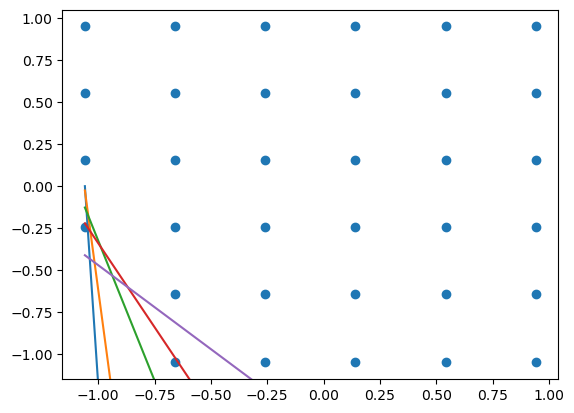

In [41]:
point_demeaned = points - np.mean(points, axis = 1)[:,None]
plt.scatter(point_demeaned[0,:], point_demeaned[1,:])

covar = np.mean(points[0,:]*points[1,:])

b_x = -np.min(point_demeaned[0,:])
b_y = -np.min(point_demeaned[1,:])

x_plot = np.linspace(np.min(point_demeaned[0,:]), np.max(point_demeaned[0,:]), 100)

vs = [0.05, 0.1, 0.3, 0.5, 1]
for v_chosen in vs:
    Delta_plot = -b_x + np.sqrt(b_x**2 + (v_chosen**2*b_y**2 + v_chosen*covar))
    #Delta_plot = -b_x+np.sqrt(b_x**2 + v_chosen**2*b_y**2)
    print(v_chosen, Delta_plot)
    y_plot = -1/v_chosen *x_plot  -b_x/v_chosen - Delta_plot/v_chosen
    
    plt.plot(x_plot, y_plot)
    plt.ylim([-b_y*1.1, np.max(point_demeaned[1,:])*1.1])

In [58]:
H = 6
I = np.random.normal(0,1, [H,3])
points_bias = np.vstack([points, np.ones([1,points.shape[1]])])

@jit
def generate_rep(I, inputs):
    g = jnn.relu(I@inputs)
    #g = I@inputs
    g_bias = jnp.vstack([g, jnp.ones(g.shape[1])[None,:]])
    return g_bias

@jit
def loss_weight_I(I):
    return jnp.sum(jnp.power(I[:,:-1],2))

@jit
def generate_R(g, outputs):
    mat0 = jnp.matmul(g, g.T)
    mat1 = jnp.matmul(g, outputs.T)
    mat2 = jnp.matmul(jnp.linalg.inv(mat0 + 0.01*jnp.eye(H+1)), mat1)
    return mat2

@jit
def loss_fit(g, R, outputs):
    preds = R.T@g
    return jnp.linalg.norm(outputs - preds) 

@jit
def loss_R(R):
    R_sub = R[:-1,:]
    return jnp.sum(jnp.power(R_sub, 2))

@jit
def loss_act(g):
    return jnp.sum(jnp.power(g[:-1,:], 2))

mu_fit = 100000
mu_G = 1
mu_R = 1
mu_I = 1
fit_thresh = 0.01

@jit
def loss(params, inputs, outputs):
    g = generate_rep(params["I"], inputs)
    R = generate_R(g, points)

    return mu_fit*jnn.relu(loss_fit(g, R, outputs)-fit_thresh) + mu_G*loss_act(g) + mu_I*loss_weight_I(params["I"]) + mu_R*loss_weight_I(R)
    
@jit
def update(params, inputs, outputs, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, inputs, outputs)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, value

random_seed = 43321432
learning_rate = 1e-4

re_init = 1
if re_init:
    key = random.PRNGKey(random_seed)
    I = random.normal(key, (H, 3))*0.001
    I = I.at[:,-1].set(2)
    optimizer = optax.adam(learning_rate)
    # Obtain the `opt_state` that contains statistics for the optimizer.
    params = {'I': I}
    opt_state = optimizer.init(params)
print(loss(params, points_bias, points))
min_loss = np.infty

543174.44


In [59]:
# Optimisation, run and re-run until it stops hitting new records
T = 10000000
print_iter = 10000

for t in range(T):
    params, opt_state, loss = update(params, points_bias, points, opt_state)

    if t % print_iter == 0:
        g = generate_rep(params["I"], points_bias)
        R = generate_R(g, points)

        L_f = loss_fit(g, R, points)
        L_a = loss_act(g)
        L_R = loss_weight_I(R)
        L_I = loss_weight_I(params["I"])    
        print(f"Step {t}, Loss: {loss:.5f}, Fit: {L_f:.5f}, Act: {L_a:.5f}, R: {L_R:.5f}, I: {L_I:.5f}")
        #print(f"Step {t}, Loss: {loss:.5f}")#, Fit: {L_f:.5f}, Act: {L_a:.5f}, Wei: {L_w:.5f}, R: {L_R:.5f}, Pos: {L_p:.5f}, PI: {L_PI:.5f}")

        min_this_step = 0

    if loss < min_loss:
        params_best = params
        min_loss = loss
        if min_this_step == 0:
            print(f'New min! {loss}')
            min_this_step = 1

Step 0, Loss: 543174.43750, Fit: 5.42533, Act: 815.94580, R: 14.62855, I: 0.00002
New min! 543174.4375
Step 10000, Loss: 1086.98938, Fit: 0.01595, Act: 491.41406, R: 4.00061, I: 0.46413
New min! 1086.9893798828125
Step 20000, Loss: 104.84177, Fit: 0.00996, Act: 101.56303, R: 2.51698, I: 0.74095
New min! 104.84176635742188
Step 30000, Loss: 54.81534, Fit: 0.00991, Act: 51.46263, R: 2.61039, I: 0.74127
New min! 54.71992874145508
Step 40000, Loss: 50.69685, Fit: 0.00992, Act: 47.31995, R: 2.63532, I: 0.74035
New min! 50.63199234008789
Step 50000, Loss: 46.24473, Fit: 0.00998, Act: 42.89402, R: 2.60620, I: 0.74283
New min! 46.24473190307617
Step 60000, Loss: 43.37332, Fit: 0.00994, Act: 40.12069, R: 2.50454, I: 0.74693
New min! 43.32204818725586
Step 70000, Loss: 41.15499, Fit: 0.00991, Act: 37.95827, R: 2.44207, I: 0.75492
New min! 41.09829330444336
Step 80000, Loss: 40.25816, Fit: 0.00994, Act: 37.01815, R: 2.48552, I: 0.75330
New min! 40.195960998535156
Step 90000, Loss: 40.10789, Fit: 

KeyboardInterrupt: 

In [60]:
print(min_loss)

39.334114


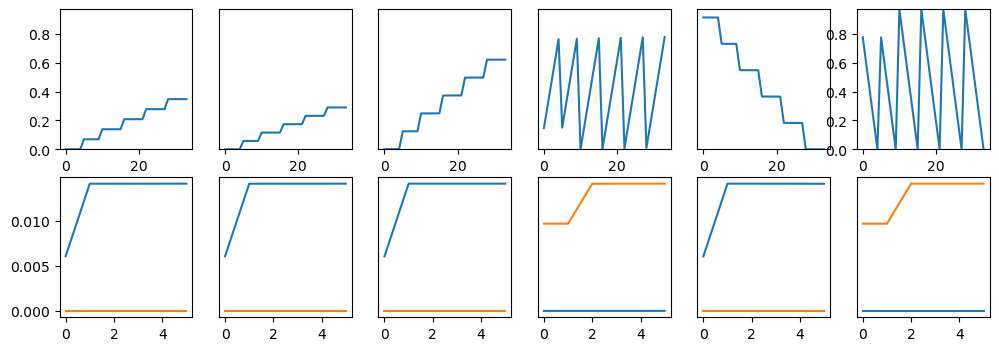

In [61]:
input_currents = jnn.relu(params_best['I']@ points_bias)
max_current = np.max(input_currents)
min_current = np.min(input_currents)
plt.figure(figsize = (2*H, 4))
for neuron in range(H):
    plt.subplot(2,H,neuron+1)
    plt.plot(input_currents[neuron,:])
    plt.ylim([min_current, max_current])

    if neuron%5 != 0:
        plt.yticks([])

unique_x = np.unique(points[0,:])
unique_y = np.unique(points[1,:])
mean_values_x = np.zeros([H, len(unique_x)])
mean_values_y = np.zeros([H, len(unique_y)])
for val_ind, val in enumerate(unique_x):
    mean_values_x[:,val_ind] = np.var(input_currents[:,points[0,:] == val], axis = 1)
for val_ind, val in enumerate(unique_y):
    mean_values_y[:,val_ind] = np.var(input_currents[:,points[1,:] == val], axis = 1)


min_mean = np.min([np.min(mean_values_x), np.min(mean_values_y)])
max_mean = np.max([np.max(mean_values_x), np.max(mean_values_y)])

for neuron in range(H):
    plt.subplot(2,H,H+1+neuron)
    plt.plot(mean_values_x[neuron,:])
    plt.plot(mean_values_y[neuron,:])
    #plt.ylim([min_mean, max_mean])

    if neuron%H != 0:
        plt.yticks([])


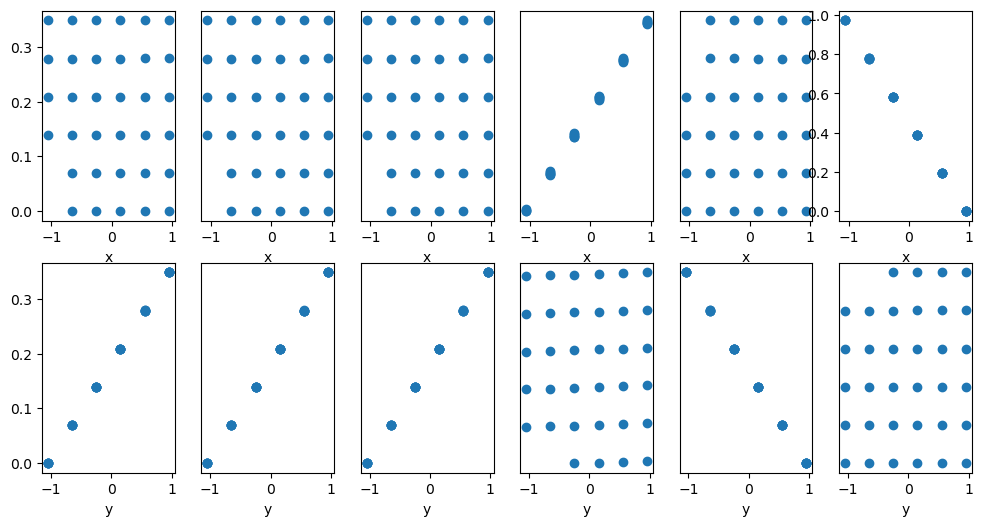

In [62]:
plt.figure(figsize = (2*H, 6))
for neuron in range(H):
    plt.subplot(2,H,neuron+1)
    plt.scatter(points[0,:], input_currents[neuron,:])
    #plt.ylim([min_current, max_current])
    plt.xlabel('x')

    if neuron%5 != 0:
        plt.yticks([])

for neuron in range(H):
    plt.subplot(2,H,H+neuron+1)
    plt.scatter(points[1,:], input_currents[neuron,:])
    #plt.ylim([min_current, max_current])

    if neuron%H != 0:
        plt.yticks([])

    plt.xlabel('y')
plt.show()

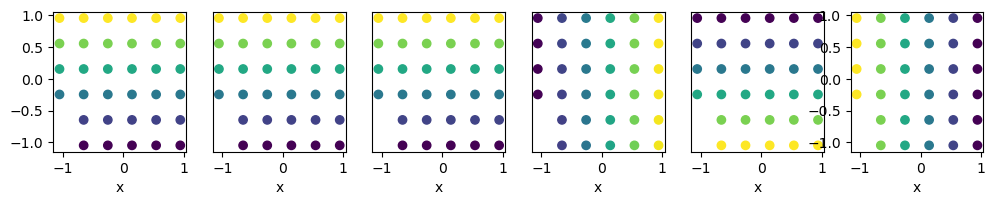

In [63]:
plt.figure(figsize = (2*H, 4))
for neuron in range(H):
    plt.subplot(2,H,neuron+1)
    plt.scatter(points[0,:], points[1,:], c = input_currents[neuron,:])
    #plt.ylim([min_current, max_current])
    plt.xlabel('x')

    if neuron%5 != 0:
        plt.yticks([])
plt.show()

In [27]:
g_best.shape

NameError: name 'g_best' is not defined

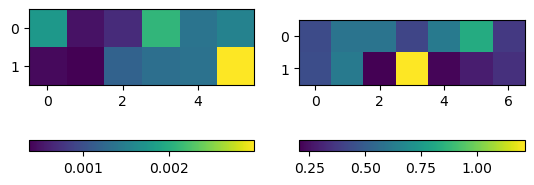

In [264]:
plt.subplot(1,2,1)
plt.imshow(np.abs(I[:,:-1].T))
plt.colorbar(orientation='horizontal')

plt.subplot(1,2,2)
plt.imshow(np.abs(R.T))
plt.colorbar(orientation='horizontal')
